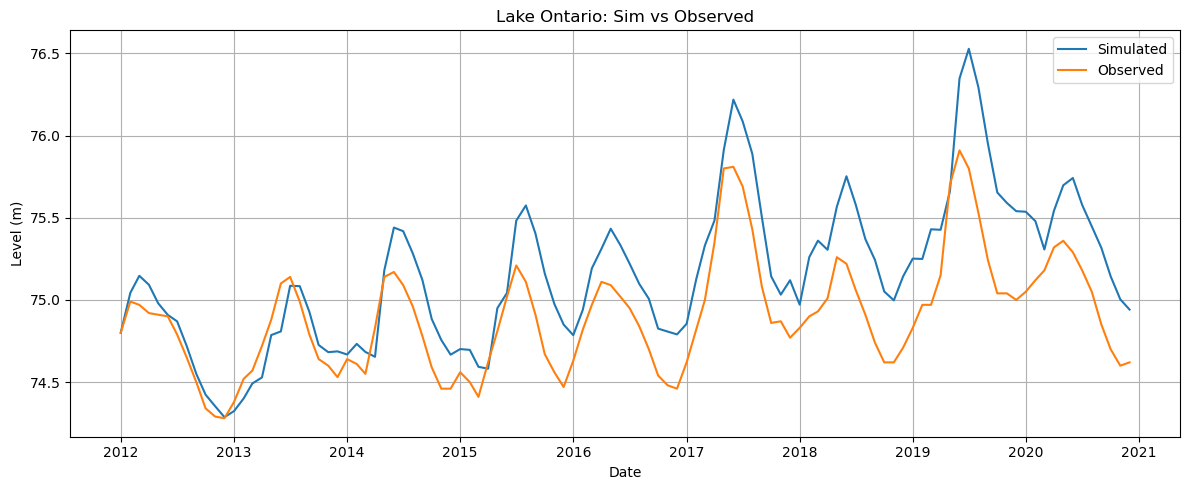

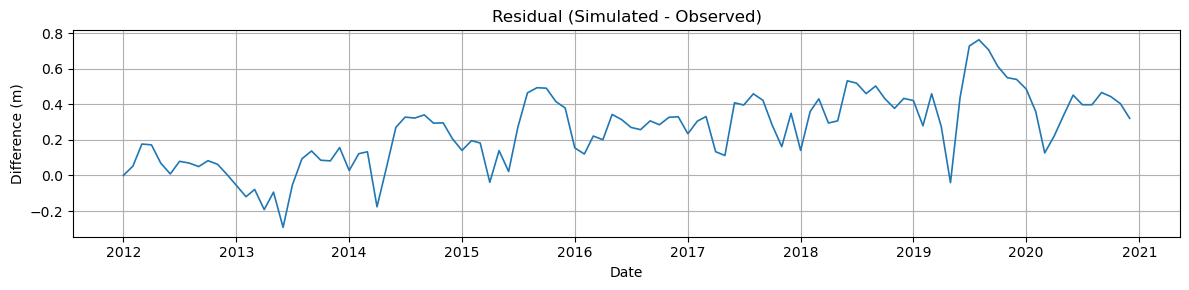

In [ ]:
# Lake Ontario water level model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar

# Lake Ontario configuration
A = 1.896e10  # surface area in m²
EXCEL_FILE = 'data/Problem_D_Great_Lakes_trimmed.xlsx'
PRECIP_CSV = 'data/prc_ont_lake.csv'
EVAP_CSV   = 'data/evaporation_ont.csv'
RUNOFF_CSV = 'data/runoff_ont_arm.csv'


def load_levels():
    """
    Load observed lake levels from the Excel file and return as a time-indexed pd.Series.
    Only data from 2012 to 2020 is returned.
    """
    xls = pd.ExcelFile(EXCEL_FILE)
    df = pd.read_excel(xls, 'Lake Ontario')
    long = df.melt(id_vars='Year', var_name='Month', value_name='Level_m')
    long['Month'] = long['Month'].str.strip()
    long['Date'] = pd.to_datetime(long['Year'].astype(str) + '-' + long['Month'],
                                  format='%Y-%b')
    series = long.set_index('Date')['Level_m'].sort_index()
    return series.loc['2012-01-01':'2020-12-31']


def load_flow(sheet_name, col_name):
    """
    Load monthly river flow data from the specified sheet in the Excel file.
    Returns a pd.Series indexed by date, limited to 2012-2020.
    """
    xls = pd.ExcelFile(EXCEL_FILE)
    df = pd.read_excel(xls, sheet_name)
    long = df.melt(id_vars='Year', var_name='Month', value_name='Flow_cms')
    long['Month'] = long['Month'].str.strip()
    long['Date'] = pd.to_datetime(long['Year'].astype(str) + '-' + long['Month'],
                                  format='%Y-%b')
    return long.set_index('Date')['Flow_cms'].sort_index().loc['2012-01-01':'2020-12-31']


def load_monthly_csv(filename, value_name):
    """
    Load monthly precipitation or evaporation data from CSV.
    Returns a pd.Series indexed by date, limited to 2012-2020.
    """
    df = pd.read_csv(filename, index_col=0)
    df.index.name = 'Year'
    long = df.reset_index().melt(id_vars='Year', var_name='Month', value_name=value_name)
    long['Month'] = long['Month'].str.strip()
    long['Date'] = pd.to_datetime(long['Year'].astype(str) + '-' + long['Month'],
                                  format='%Y-%b')
    return long.set_index('Date')[value_name].sort_index().loc['2012-01-01':'2020-12-31']


def load_runoff():
    """
    Load watershed runoff data from CSV and return flow (cms) as a pd.Series.
    Data is limited to 2012-2020.
    """
    df = pd.read_csv(RUNOFF_CSV, sep=r',\s*', engine='python')
    df.columns = df.columns.str.strip()
    df['Date'] = pd.to_datetime(df['YYYY-MM'], format='%Y-%m')
    series = df.set_index('Date')['flow_cms'].sort_index()
    return series.loc['2012-01-01':'2020-12-31']


def compute_net_inputs(df):
    """
    Compute net precipitation minus evaporation (converted to meters),
    calculate the number of seconds in each month,
    compute runoff height contribution, and sum net inputs.
    """
    df['P_minus_E_m'] = (df['Precip_mm'] - df['Evap_mm']) / 1000.0
    df['Seconds'] = df.index.to_series().apply(
        lambda d: calendar.monthrange(d.year, d.month)[1] * 86400
    )
    df['Runoff_h'] = df['Runoff_cms'] * df['Seconds'] / A
    df['s_t'] = df['P_minus_E_m'] + df['Runoff_h']
    return df


def simulate_water_level(df):
    """
    Run the full mass-balance simulation to estimate lake water levels over time.
    Uses inflow, outflow, and net inputs to update water level monthly.
    """
    dates = df.index
    w = np.zeros(len(dates))
    w[0] = df['Level_m'].iloc[0]
    for i in range(len(dates) - 1):
        sec = df['Seconds'].iloc[i]
        w[i + 1] = (
            w[i]
            + df['Inflow_cms'].iloc[i] * sec / A
            - df['Outflow_cms'].iloc[i] * sec / A
            + df['s_t'].iloc[i]
        )
    return pd.Series(w, index=dates, name='Simulated')


def main():
    """
    Main function to load data, perform computations, simulate water levels,
    and generate plots comparing observed and simulated data.
    """
    # Load all necessary data series
    obs = load_levels()
    inflow = load_flow('Niagara River', 'Inflow_cms')
    outflow = load_flow('St. Lawrence River', 'Outflow_cms')
    precip = load_monthly_csv(PRECIP_CSV, 'Precip_mm')
    evap   = load_monthly_csv(EVAP_CSV,   'Evap_mm')
    runoff = load_runoff()

    # Combine all inputs into a single DataFrame, dropping any incomplete months
    df = pd.DataFrame({
        'Level_m'    : obs,
        'Inflow_cms' : inflow,
        'Outflow_cms': outflow,
        'Precip_mm'  : precip,
        'Evap_mm'    : evap,
        'Runoff_cms' : runoff
    }).dropna()

    # Calculate net inputs and simulate the lake water level time series
    df = compute_net_inputs(df)
    simulated = simulate_water_level(df)
    residual = simulated - df['Level_m']

    # Plot simulated and observed water levels for comparison
    plt.figure(figsize=(12,5))
    plt.plot(simulated, label='Simulated', linewidth=1.5)
    plt.plot(df['Level_m'], label='Observed', linewidth=1.5)
    plt.title('Lake Ontario: Sim vs Observed')
    plt.xlabel('Date'); plt.ylabel('Level (m)')
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
    # Plot the residual differences between simulated and observed levels
    plt.figure(figsize=(12,3))
    plt.plot(residual, linewidth=1.2)
    plt.title('Residual (Simulated - Observed)')
    plt.xlabel('Date'); plt.ylabel('Difference (m)')
    plt.grid(True); plt.tight_layout(); plt.show()


if __name__ == '__main__':
    main()


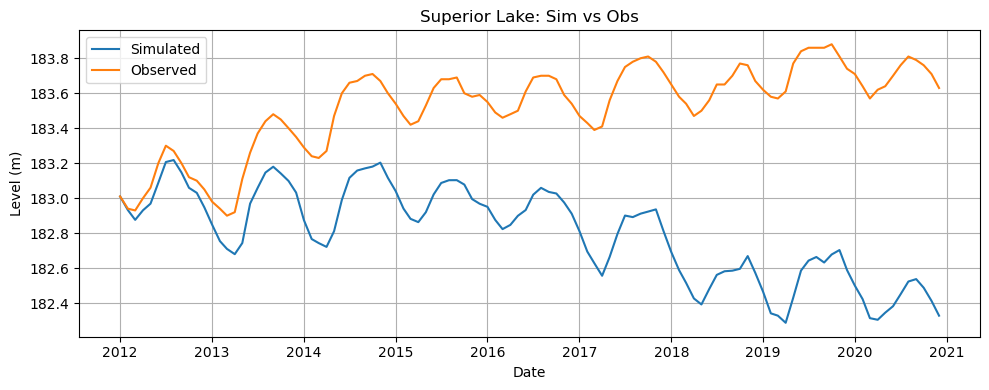

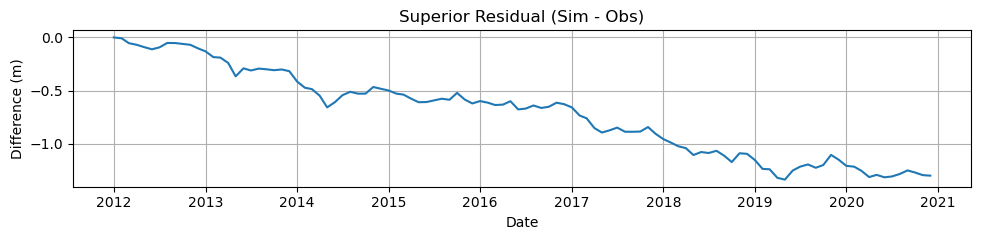

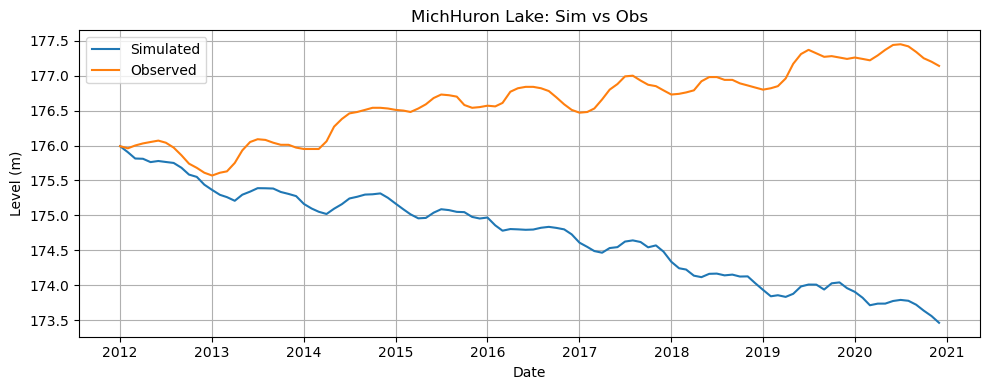

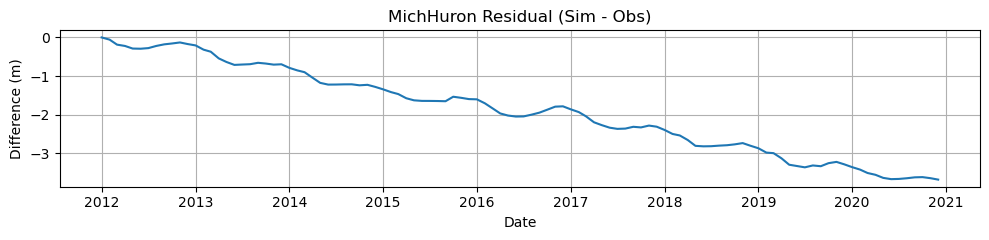

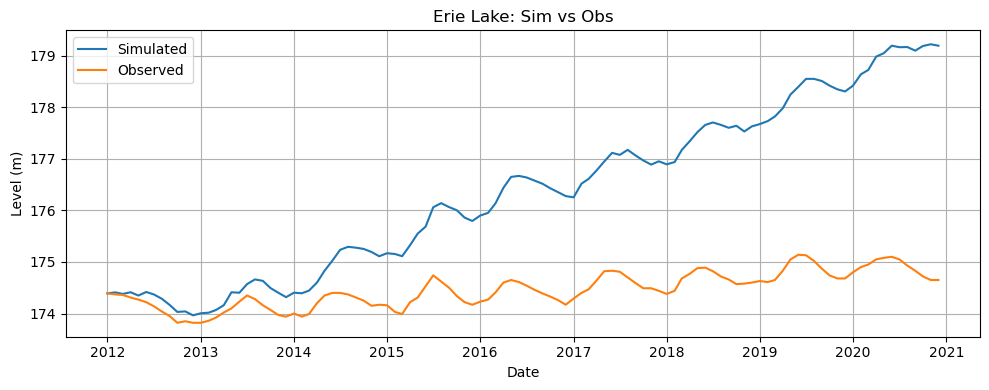

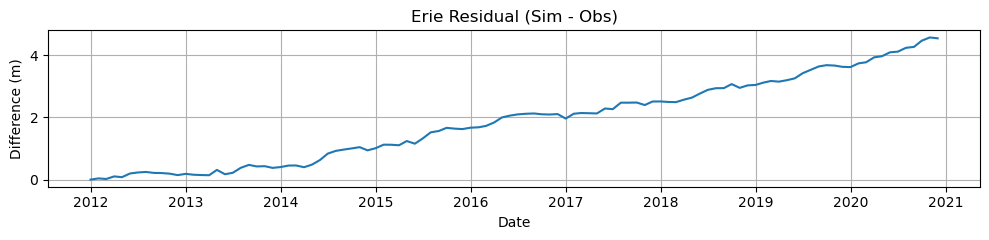

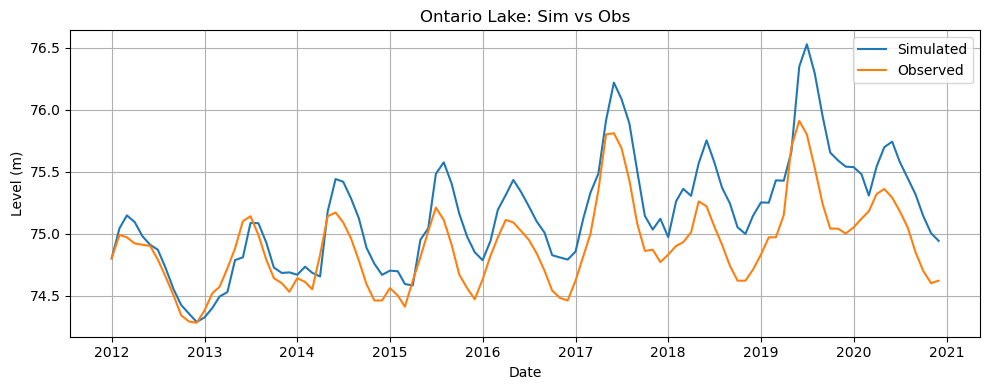

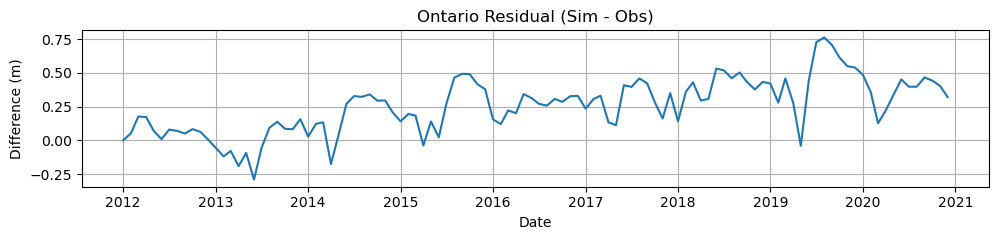

In [54]:
# Generalized Lake Model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar

# Configuration
EXCEL_FILE = 'data/Problem_D_Great_Lakes_trimmed.xlsx'

# Lake surface areas (m²)
LAKE_AREAS = {
    'Superior' : 8.21e10,
    'MichHuron': 1.176e11,
    'Erie'     : 2.57e10,
    'Ontario'  : 1.896e10
}

# Excel sheet names
LEVEL_SHEETS = {
    'Superior' : 'Lake Superior',
    'MichHuron': 'Lake Michigan and Lake Huron',
    'Erie'     : 'Lake Erie',
    'Ontario'  : 'Lake Ontario'
}
FLOW_SHEETS = {
    'StMary'    : "St. Mary's River",
    'Detroit'   : 'Detroit River',
    'Niagara'   : 'Niagara River',
    'StLawrence': 'St. Lawrence River'
}
# Map lakes to inflow/outflow keys
LAKE_FLOW_MAP = {
    'Superior' : (None,     'StMary'),
    'MichHuron': ('StMary','Detroit'),
    'Erie'     : ('Detroit','Niagara'),
    'Ontario'  : ('Niagara','StLawrence')
}

# CSV filenames for precipitation, evaporation, runoff
PRECIP_FILES = {
    'Superior' :'data/prc_sup_lake.csv',
    'MichHuron':'data/prc_mic_lake.csv',
    'Erie'     :'data/prc_eri_lake.csv',
    'Ontario'  :'data/prc_ont_lake.csv'
}
EVAP_FILES = {
    'Superior' :'data/evaporation_sup.csv',
    'MichHuron':'data/evaporation_mic.csv',
    'Erie'     :'data/evaporation_eri.csv',
    'Ontario'  :'data/evaporation_ont.csv'
}
RUNOFF_FILES = {
    'Superior' :'data/runoff_sup_arm.csv',
    'MichHuron':'data/runoff_mic_arm.csv',
    'Erie'     :'data/runoff_eri_arm.csv',
    'Ontario'  :'data/runoff_ont_arm.csv'
}

# —— Data Loaders —— #
def load_levels():
    """Load monthly lake level series for all lakes."""
    xls = pd.ExcelFile(EXCEL_FILE)
    levels = {}
    for lake, sheet in LEVEL_SHEETS.items():
        df = pd.read_excel(xls, sheet)
        long = df.melt(id_vars='Year', var_name='Month', value_name='Level_m')
        long['Month'] = long['Month'].str.strip()
        long['Date']  = pd.to_datetime(long['Year'].astype(str)+'-'+long['Month'], format='%Y-%b')
        series = long.set_index('Date')['Level_m'].sort_index()
        levels[lake] = series.loc['2012-01-01':'2020-12-31']
    return levels

def load_flows():
    """Load monthly river flows for all flow keys."""
    xls = pd.ExcelFile(EXCEL_FILE)
    flows = {}
    for key, sheet in FLOW_SHEETS.items():
        df = pd.read_excel(xls, sheet)
        long = df.melt(id_vars='Year', var_name='Month', value_name='Flow_cms')
        long['Month'] = long['Month'].str.strip()
        long['Date']  = pd.to_datetime(long['Year'].astype(str)+'-'+long['Month'], format='%Y-%b')
        flows[key] = long.set_index('Date')['Flow_cms'].sort_index().loc['2012-01-01':'2020-12-31']
    return flows

def load_monthly_csv(fname, col):
    """Load a monthly CSV (precip/evap) into a pd.Series."""
    df = pd.read_csv(fname, index_col=0)
    df.index.name = 'Year'
    long = df.reset_index().melt(id_vars='Year', var_name='Month', value_name=col)
    long['Month'] = long['Month'].str.strip()
    long['Date']  = pd.to_datetime(long['Year'].astype(str)+'-'+long['Month'], format='%Y-%b')
    return long.set_index('Date')[col].sort_index().loc['2012-01-01':'2020-12-31']

def load_runoff():
    """Load monthly runoff CSVs for all lakes."""
    runoff = {}
    for lake, fname in RUNOFF_FILES.items():
        df = pd.read_csv(fname, sep=r',\s*', engine='python')
        df.columns = df.columns.str.strip()
        df['Date'] = pd.to_datetime(df['YYYY-MM'], format='%Y-%m')
        series = df.set_index('Date')['flow_cms'].sort_index().loc['2012-01-01':'2020-12-31']
        runoff[lake] = series
    return runoff

# —— Computation Routines —— #
def prepare_data(lake, levels, flows, precip, evap, runoff):
    """
    Merge all hydrologic inputs into a DataFrame and compute net inputs.
    """
    df = pd.DataFrame({
        'Level_m'    : levels[lake],
        'Inflow_cms' : flows[LAKE_FLOW_MAP[lake][0]] if LAKE_FLOW_MAP[lake][0] else 0.0,
        'Outflow_cms': flows[LAKE_FLOW_MAP[lake][1]],
        'Precip_mm'  : precip[lake],
        'Evap_mm'    : evap[lake],
        'Runoff_cms' : runoff[lake]
    }).dropna()
    # net precipitation minus evaporation (m)
    df['P_minus_E_m'] = (df['Precip_mm'] - df['Evap_mm']) / 1000.0
    # seconds in each month
    df['Seconds'] = df.index.to_series().apply(
        lambda d: calendar.monthrange(d.year, d.month)[1] * 86400
    )
    # runoff height contribution (m)
    area = LAKE_AREAS[lake]
    df['Runoff_h'] = df['Runoff_cms'] * df['Seconds'] / area
    # total local input
    df['s_t']      = df['P_minus_E_m'] + df['Runoff_h']
    return df

def simulate_mass_balance(df, lake):
    """
    Run the hydrologic mass balance simulation (no control).
    Returns a pd.Series of simulated levels.
    """
    dates = df.index
    area = LAKE_AREAS[lake]
    w = np.zeros(len(dates))
    w[0] = df['Level_m'].iloc[0]
    for i in range(len(dates)-1):
        sec = df['Seconds'].iloc[i]
        w[i+1] = (
            w[i]
            + df['Inflow_cms'].iloc[i]  * sec / area
            - df['Outflow_cms'].iloc[i] * sec / area
            + df['s_t'].iloc[i]
        )
    return pd.Series(w, index=dates, name='Simulated')

# —— Main Execution —— #
def main():
    # Load all data
    levels = load_levels()
    flows  = load_flows()
    precip = {lk: load_monthly_csv(PRECIP_FILES[lk], 'Precip_mm') for lk in LEVEL_SHEETS}
    evap   = {lk: load_monthly_csv(EVAP_FILES[lk], 'Evap_mm')    for lk in LEVEL_SHEETS}
    runoff = load_runoff()

    # Process each lake
    for lake in LEVEL_SHEETS:
        # Prepare merged DataFrame
        df = prepare_data(lake, levels, flows, precip, evap, runoff)
        # Simulate the lake’s mass-balance
        sim = simulate_mass_balance(df, lake)
        res = sim - df['Level_m']

        # Plot simulation vs observed
        plt.figure(figsize=(10,4))
        plt.plot(sim, label='Simulated')
        plt.plot(df['Level_m'], label='Observed')
        plt.title(f'{lake} Lake: Sim vs Obs')
        plt.xlabel('Date'); plt.ylabel('Level (m)')
        plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

        # Plot residual (difference)
        plt.figure(figsize=(10,2.5))
        plt.plot(res)
        plt.title(f'{lake} Residual (Sim - Obs)')
        plt.xlabel('Date'); plt.ylabel('Difference (m)')
        plt.grid(True); plt.tight_layout(); plt.show()

if __name__ == '__main__':
    main()


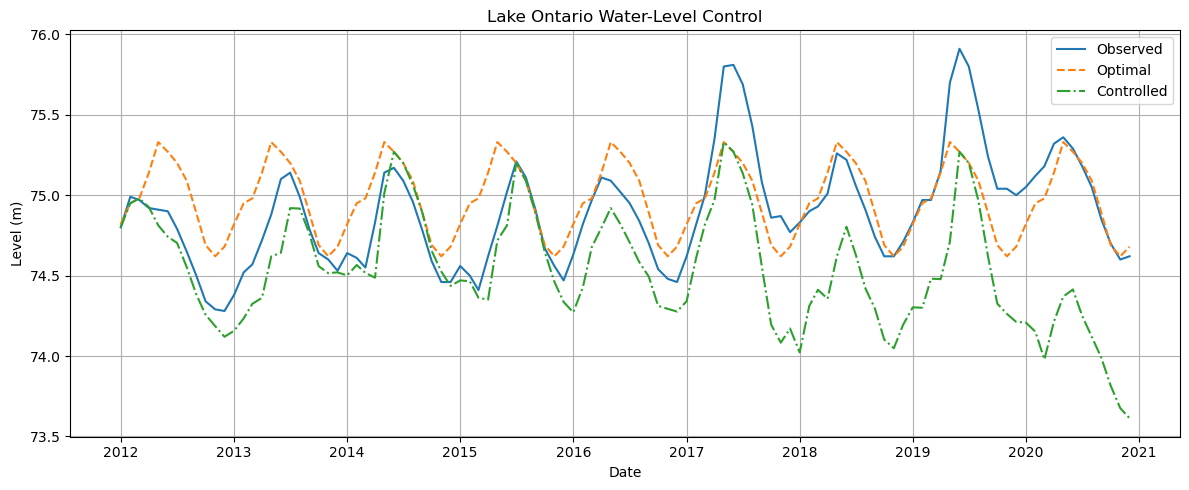

In [55]:
# Optimal Control of Lake Ontario Water Level

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar

# Configuration
A = 1.896e10  # Lake Ontario surface area (m²)
EXCEL_FILE  = 'data/Problem_D_Great_Lakes_trimmed.xlsx'
PRECIP_CSV  = 'data/prc_ont_lake.csv'
EVAP_CSV    = 'data/evaporation_ont.csv'
RUNOFF_CSV  = 'data/runoff_ont_arm.csv'

# Trigger limits per calendar month
TRIGGER_HIGH = {1:75.03,2:75.14,3:75.16,4:75.27,5:75.40,6:75.50,
                7:75.55,8:75.52,9:75.43,10:75.34,11:75.20,12:75.08}
TRIGGER_LOW  = {1:74.28,2:74.26,3:74.28,4:74.40,5:74.49,6:74.55,
                7:74.58,8:74.55,9:74.47,10:74.39,11:74.33,12:74.30}

def load_levels():
    """Load Lake Ontario observed levels as a pd.Series."""
    xls = pd.ExcelFile(EXCEL_FILE)
    df = pd.read_excel(xls, 'Lake Ontario')
    long = df.melt(id_vars='Year', var_name='Month', value_name='Level_m')
    long['Month'] = long['Month'].str.strip()
    long['Date'] = pd.to_datetime(long['Year'].astype(str)+'-'+long['Month'],format='%Y-%b')
    return long.set_index('Date')['Level_m'].sort_index().loc['2012-01-01':'2020-12-31']

def load_flow(sheet_name):
    """Load and return a monthly flow series from the given Excel sheet."""
    xls = pd.ExcelFile(EXCEL_FILE)
    df = pd.read_excel(xls, sheet_name)
    long = df.melt(id_vars='Year', var_name='Month', value_name='Flow_cms')
    long['Month'] = long['Month'].str.strip()
    long['Date'] = pd.to_datetime(long['Year'].astype(str)+'-'+long['Month'],format='%Y-%b')
    return long.set_index('Date')['Flow_cms'].sort_index().loc['2012-01-01':'2020-12-31']

def load_monthly_csv(filename, col_name):
    """Load a monthly CSV file and return a pd.Series of col_name."""
    df = pd.read_csv(filename, index_col=0)
    df.index.name = 'Year'
    long = df.reset_index().melt(id_vars='Year', var_name='Month', value_name=col_name)
    long['Month'] = long['Month'].str.strip()
    long['Date']  = pd.to_datetime(long['Year'].astype(str)+'-'+long['Month'],format='%Y-%b')
    return long.set_index('Date')[col_name].sort_index().loc['2012-01-01':'2020-12-31']

def load_runoff():
    """Load runoff series from CSV and return a pd.Series."""
    df = pd.read_csv(RUNOFF_CSV, sep=r',\s*', engine='python')
    df.columns = df.columns.str.strip()
    df['Date'] = pd.to_datetime(df['YYYY-MM'], format='%Y-%m')
    return df.set_index('Date')['flow_cms'].sort_index().loc['2012-01-01':'2020-12-31']

def compute_net_inputs(df):
    """Compute P_minus_E, Seconds, Runoff_h, and s_t columns."""
    df['P_minus_E_m'] = (df['Precip_mm'] - df['Evap_mm']) / 1000.0
    df['Seconds'] = df.index.to_series().apply(lambda d: calendar.monthrange(d.year,d.month)[1]*86400)
    df['Runoff_h'] = df['Runoff_cms'] * df['Seconds'] / A
    df['s_t'] = df['P_minus_E_m'] + df['Runoff_h']
    return df

def compute_monthly_stats(series):
    """Return P30, P70, and mean (Wbar) per calendar month."""
    grouped = series.groupby(series.index.month)
    return grouped.quantile(0.3), grouped.quantile(0.7), grouped.mean()

def utility(w, m, P30, P70, Wbar):
    """Original utility function with triggers."""
    u_ship  = 0.5*(w-P70[m])**2 if w>P70[m] else -0.5
    u_dock  = -0.5*(w-P30[m])**2 if w<P30[m] else 0.5
    u_env   = 1 if abs(w-Wbar[m])<0.05*Wbar[m] else -2
    midpoint= (P30[m]+P70[m])/2
    u_shore = -(w-midpoint)**2
    penalty = 0
    if w > TRIGGER_HIGH[m]:
        penalty = -10*(w-TRIGGER_HIGH[m])**2
    elif w < TRIGGER_LOW[m]:
        penalty = -10*(TRIGGER_LOW[m]-w)**2
    return u_ship+u_dock+u_env+u_shore+penalty

def compute_optimal(series):
    """Grid-search optimal level per timestamp."""
    P30, P70, Wbar = compute_monthly_stats(series)
    candidates = np.linspace(74.0,76.0,201)
    opt = []
    for d in series.index:
        m=d.month
        utils=[utility(x,m,P30,P70,Wbar) for x in candidates]
        opt.append(candidates[np.argmax(utils)])
    return pd.Series(opt,index=series.index,name='WO_opt')

def simulate_control(df, WO_opt):
    """P-only control simulation toward WO_opt with max 0.5m release."""
    dates=df.index; n=len(dates)
    W_ctrl=np.zeros(n); W_ctrl[0]=df['Observed'].iloc[0]
    for i in range(n-1):
        sec= df['Seconds'].iloc[i]
        w_noD= W_ctrl[i]+(df['Inflow_cms'].iloc[i]-df['Outflow_cms'].iloc[i])*sec/A+df['s_t'].iloc[i]
        err= w_noD-WO_opt.iloc[i+1]
        u= np.clip(err,0,0.5)
        W_ctrl[i+1]= w_noD-u
    return pd.Series(W_ctrl,index=dates,name='W_ctrl')

def main():
    # Load all inputs
    levels = load_levels()
    inflow = load_flow('Niagara River')
    outflow= load_flow('St. Lawrence River')
    precip = load_monthly_csv(PRECIP_CSV,'Precip_mm')
    evap   = load_monthly_csv(EVAP_CSV,  'Evap_mm')
    runoff = load_runoff()

    # Merge into DataFrame
    df=pd.DataFrame({
        'Observed':levels,
        'Inflow_cms':inflow,
        'Outflow_cms':outflow,
        'Precip_mm':precip,
        'Evap_mm':evap,
        'Runoff_cms':runoff
    }).dropna()

    # Compute inputs and simulate
    df=compute_net_inputs(df)
    WO_opt=compute_optimal(df['Observed'])
    df['WO_opt']=WO_opt
    W_ctrl=simulate_control(df,WO_opt)
    df['W_ctrl']=W_ctrl

    # Plot comparison
    plt.figure(figsize=(12,5))
    plt.plot(df['Observed'], label='Observed')
    plt.plot(df['WO_opt'],   '--', label='Optimal')
    plt.plot(df['W_ctrl'],  '-.', label='Controlled')
    plt.title('Lake Ontario Water-Level Control')
    plt.xlabel('Date'); plt.ylabel('Level (m)')
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

if __name__=='__main__':
    main()

If the water level exceeds that month’s Plan 2014 High Trigger, we impose a penalty;  
likewise, if it falls below the Low Trigger, we apply a symmetric penalty. 

Adding this penalty produces a naturally seasonal target level that automatically suppresses excessive peaks, aligning with the Plan 2014 requirements.

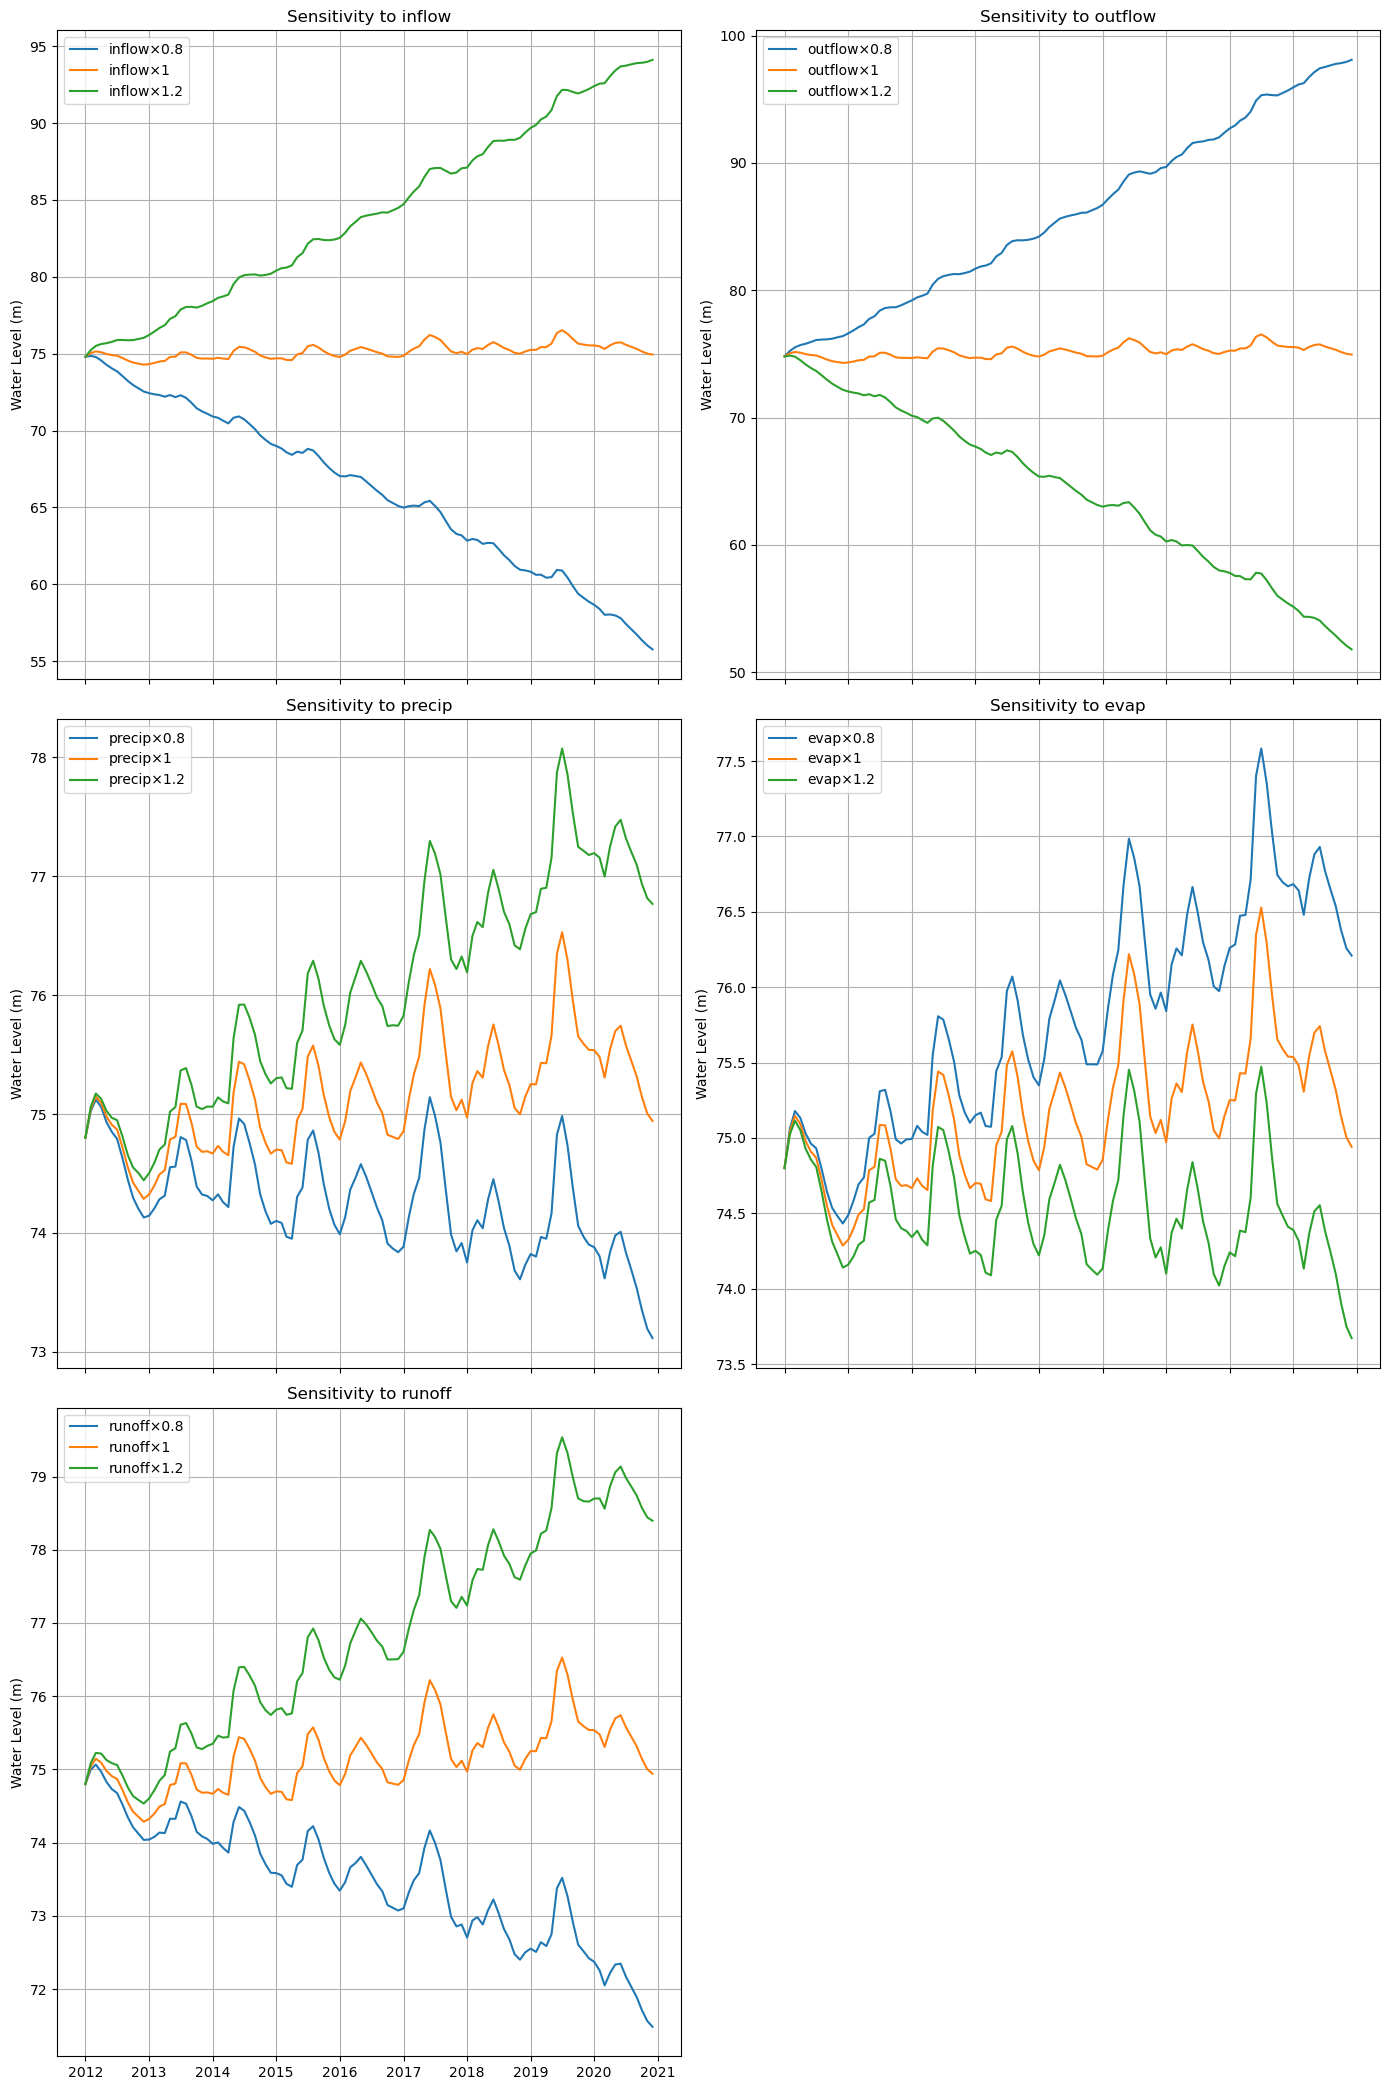


Utility Weights Sensitivity Analysis:
      Param  Value   AvgDev
   shipping    0.5 0.000000
   shipping    1.0 0.000000
   shipping    1.5 0.315133
   shipping    2.0 0.612608
environment    0.5 0.000000
environment    1.0 0.000000
environment    1.5 0.000000
environment    2.0 0.000000


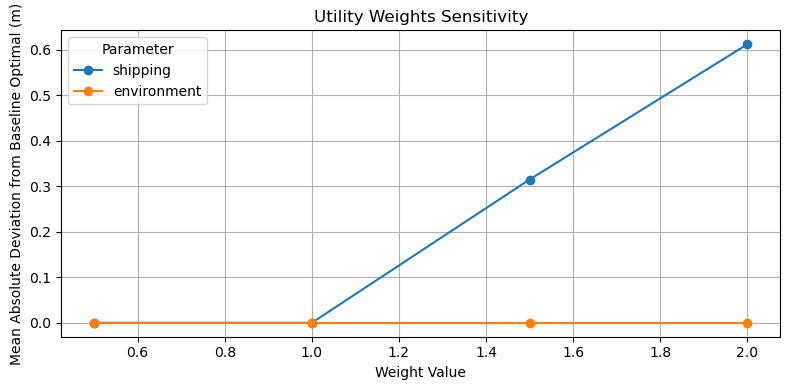


Sensitivity Metrics Summary:
Parameter  Factor  Mean Change (%)  Std Change (%)  RMSE Change (%)
   inflow     0.8       -12.009377     1079.116004      1636.165340
   inflow     1.0         0.000000        0.000000         0.000000
   inflow     1.2        12.009377     1207.149659       -59.008182
  outflow     0.8        14.507257     1465.645141       -59.235052
  outflow     1.0         0.000000        0.000000         0.000000
  outflow     1.2       -14.507257     1338.185618      2005.007205
   precip     0.8        -1.191428       -5.697777        89.056180
   precip     1.0         0.000000        0.000000         0.000000
   precip     1.2         1.191428      100.451966       -21.146024
     evap     0.8         0.852236       63.976675       -17.260852
     evap     1.0         0.000000        0.000000         0.000000
     evap     1.2        -0.852236      -20.755774        39.007013
   runoff     0.8        -2.253571       82.280902       236.539847
   runoff     1.0 

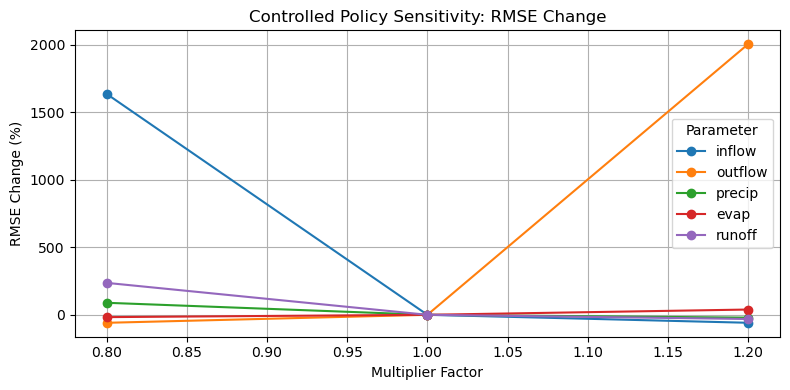

In [56]:
# Sensitivity Analysis

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar

# —— Configuration —— #
EXCEL_FILE = 'data/Problem_D_Great_Lakes_trimmed.xlsx'
A = 1.896e10         # Lake Ontario surface area (m²)
MAX_RELEASE = 0.5    # Max monthly release (m)

# Trigger limits per month
TRIGGER_HIGH = {1:75.03,2:75.14,3:75.16,4:75.27,5:75.40,6:75.50,
                7:75.55,8:75.52,9:75.43,10:75.34,11:75.20,12:75.08}
TRIGGER_LOW  = {1:74.28,2:74.26,3:74.28,4:74.40,5:74.49,6:74.55,
                7:74.58,8:74.55,9:74.47,10:74.39,11:74.33,12:74.30}

# --- Data Loaders --- #
def load_levels():
    """Load Lake Ontario monthly levels."""
    xls = pd.ExcelFile(EXCEL_FILE)
    df = pd.read_excel(xls, 'Lake Ontario')
    long = df.melt(id_vars='Year', var_name='Month', value_name='Level_m')
    long['Month'] = long['Month'].str.strip()
    long['Date'] = pd.to_datetime(long['Year'].astype(str)+'-'+long['Month'], format='%Y-%b')
    return long.set_index('Date')['Level_m'].sort_index().loc['2012-01-01':'2020-12-31']

def load_flow(sheet):
    """Load monthly river flow for given sheet."""
    xls = pd.ExcelFile(EXCEL_FILE)
    df = pd.read_excel(xls, sheet)
    long = df.melt(id_vars='Year', var_name='Month', value_name='Flow_cms')
    long['Month'] = long['Month'].str.strip()
    long['Date'] = pd.to_datetime(long['Year'].astype(str)+'-'+long['Month'], format='%Y-%b')
    return long.set_index('Date')['Flow_cms'].sort_index().loc['2012-01-01':'2020-12-31']

def load_monthly_csv(file, col_name):
    """Load and return a monthly series from CSV."""
    df = pd.read_csv(file, index_col=0)
    df.index.name = 'Year'
    long = df.reset_index().melt(id_vars='Year', var_name='Month', value_name=col_name)
    long['Month'] = long['Month'].str.strip()
    long['Date'] = pd.to_datetime(long['Year'].astype(str)+'-'+long['Month'], format='%Y-%b')
    return long.set_index('Date')[col_name].sort_index().loc['2012-01-01':'2020-12-31']

def load_runoff():
    """Load monthly runoff from CSV."""
    df = pd.read_csv('data/runoff_ont_arm.csv', sep=r',\s*', engine='python')
    df.columns = df.columns.str.strip()
    df['Date'] = pd.to_datetime(df['YYYY-MM'], format='%Y-%m')
    return df.set_index('Date')['flow_cms'].sort_index().loc['2012-01-01':'2020-12-31']

# --- Analysis Functions --- #

def compute_monthly_stats(series):
    """
    Compute 30th percentile, 70th percentile, and mean for each calendar month.

    Parameters:
    series (pd.Series): Time series of water levels indexed by datetime.

    Returns:
    tuple of pd.Series:
        P30  - 30th percentile for each calendar month (index 1 through 12).
        P70  - 70th percentile for each calendar month.
        Wbar - Mean water level for each calendar month.
    """
    grouped = series.groupby(series.index.month)
    P30 = grouped.quantile(0.30)
    P70 = grouped.quantile(0.70)
    Wbar = grouped.mean()
    return P30, P70, Wbar

def make_util(P30, P70, Wbar, weights):
    """
    Build a parameterized utility function for Lake Ontario:
      - Shipping term weighted by weights['shipping']
      - Docking term weighted by weights['shipping']
      - Environment term weighted by weights['environment']
      - Shore term weighted by weights['environment']
      - Trigger penalties weighted by weights['environment']
    """
    def u(w, m):
        # shipping term (penalize above P70)
        u_ship = weights['shipping'] * (w - P70[m])**2 if w > P70[m] else -weights['shipping']
        # docking term (penalize below P30)
        u_dock = weights['shipping'] * (P30[m] - w)**2 if w < P30[m] else -weights['shipping']
        # environment term (reward/penalty around mean)
        if abs(w - Wbar[m]) < 0.05 * Wbar[m]:
            u_env =  weights['environment']
        else:
            u_env = -2 * weights['environment']
        # shore term (quadratic around midpoint)
        midpoint = (P30[m] + P70[m]) / 2
        u_shore = -weights['environment'] * (w - midpoint)**2
        # trigger penalties (heavy penalty outside trigger bounds)
        penalty = 0
        if w > TRIGGER_HIGH[m]:
            penalty = -weights['environment'] * 10 * (w - TRIGGER_HIGH[m])**2
        elif w < TRIGGER_LOW[m]:
            penalty = -weights['environment'] * 10 * (TRIGGER_LOW[m] - w)**2
        return u_ship + u_dock + u_env + u_shore + penalty
    return u

def compute_net_inputs(df):
    """Compute P_minus_E, Seconds, Runoff_h, and s_t."""
    df['P_minus_E_m'] = (df['Precip_mm'] - df['Evap_mm']) / 1000.0
    df['Seconds']     = df.index.to_series().apply(lambda d: calendar.monthrange(d.year, d.month)[1]*86400)
    df['Runoff_h']    = df['Runoff_cms'] * df['Seconds'] / A
    df['s_t']         = df['P_minus_E_m'] + df['Runoff_h']
    return df

def simulate_sensitivity(df, multipliers):
    """Return water-level series under scaled hydrology."""
    dates = df.index
    w = np.zeros(len(dates))
    w[0] = df['Level_m'].iloc[0]
    for i in range(len(dates)-1):
        sec = df['Seconds'].iloc[i]
        infl = multipliers.get('inflow',1)*df['Inflow_cms'].iloc[i]
        outf = multipliers.get('outflow',1)*df['Outflow_cms'].iloc[i]
        p    = multipliers.get('precip',1)*df['Precip_mm'].iloc[i]
        e    = multipliers.get('evap',1)*df['Evap_mm'].iloc[i]
        pe   = multipliers.get('PE',1)*df['P_minus_E_m'].iloc[i]
        ro   = multipliers.get('runoff',1)*df['Runoff_h'].iloc[i]
        w[i+1] = w[i] + (infl - outf)*sec/A + (p-e) / 1000.0 + ro
    return pd.Series(w, index=dates)

def compute_optimal_series(df, weights):
    """Grid-search optimal levels for given utility weights."""
    P30, P70, Wbar = compute_monthly_stats(df['Level_m'])
    util = make_util(P30, P70, Wbar, weights)
    candidates = np.linspace(df['Level_m'].min(), df['Level_m'].max(), 201)
    opt = [candidates[np.argmax([util(x,d.month) for x in candidates])] for d in df.index]
    return pd.Series(opt, index=df.index, name='Optimal')

def simulate_control(df, multipliers, target):
    """Closed-loop control simulation toward target series."""
    dates = df.index
    n = len(dates)
    w = np.zeros(n)
    w[0] = df['Level_m'].iloc[0]
    for i in range(n-1):
        sec = df['Seconds'].iloc[i]
        infl = multipliers.get('inflow',1)*df['Inflow_cms'].iloc[i]
        outf = multipliers.get('outflow',1)*df['Outflow_cms'].iloc[i]
        p    = multipliers.get('precip',1)*df['Precip_mm'].iloc[i]
        e    = multipliers.get('evap',1)*df['Evap_mm'].iloc[i]
        pe   = multipliers.get('PE',1)*df['P_minus_E_m'].iloc[i]
        ro   = multipliers.get('runoff',1)*df['Runoff_h'].iloc[i]
        forecast = w[i] + (infl - outf)*sec/A + (p - e) / 1000.0 + ro
        err = forecast - target.iloc[i+1]
        release = np.clip(err, 0, MAX_RELEASE)
        w[i+1] = forecast - release
    return pd.Series(w, index=dates, name='Controlled')

def run_hyd_sensitivity(df, params):
    """Run and plot hydrologic sensitivity analysis for all parameters."""
    n = len(params)
    cols = 2
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(14, 7 * rows), sharex=True)
    axes = axes.flatten()
    for ax, (param, factors) in zip(axes, params.items()):
        for f in factors:
            mult = {p:1.0 for p in params}
            mult[param] = f
            w = simulate_sensitivity(df, mult)
            ax.plot(df.index, w, label=f"{param}×{f}")
        ax.set_title(f"Sensitivity to {param}")
        ax.set_ylabel("Water Level (m)")
        ax.legend()
        ax.grid(True)
    for ax in axes[n:]:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def run_weight_sensitivity(df, baseline_weights):
    """Run utility weight sensitivity analysis and plot results."""
    print("\nUtility Weights Sensitivity Analysis:")

    weight_params = {
        'shipping': [0.5, 1.0, 1.5, 2.0],
        'environment': [0.5, 1.0, 1.5, 2.0]
    }

    uw_results = []
    baseline_opt = compute_optimal_series(df, baseline_weights)
    for param, vals in weight_params.items():
        for v in vals:
            w = baseline_weights.copy()
            w[param] = v
            opt_series = compute_optimal_series(df, w)
            aad = np.mean(np.abs(opt_series - baseline_opt))
            uw_results.append({'Param': param, 'Value': v, 'AvgDev': aad})

    uw_df = pd.DataFrame(uw_results)
    print(uw_df.to_string(index=False))

    fig, ax = plt.subplots(figsize=(8,4))
    for param in weight_params:
        sub = uw_df[uw_df['Param']==param]
        ax.plot(sub['Value'], sub['AvgDev'], marker='o', label=param)
    ax.set_xlabel('Weight Value')
    ax.set_ylabel('Mean Absolute Deviation from Baseline Optimal (m)')
    ax.set_title('Utility Weights Sensitivity')
    ax.legend(title='Parameter')
    ax.grid(True)
    plt.tight_layout()
    plt.show()

def run_control_sensitivity(df, params, base_opt):
    """Run control policy sensitivity analysis and plot RMSE changes."""
    base_series = simulate_sensitivity(df, {'inflow':1,'outflow':1,'PE':1,'runoff':1})
    base_mean = base_series.mean()
    base_std = base_series.std()

    results = []
    for param, factors in params.items():
        for f in factors:
            mult = {p:1.0 for p in params}
            mult[param] = f
            sim_series = simulate_sensitivity(df, mult)
            mean_change = (sim_series.mean() - base_mean) / base_mean * 100
            std_change = (sim_series.std() - base_std) / base_std * 100
            ctrl_series = simulate_control(df, mult, base_opt)
            rmse = np.sqrt(((ctrl_series - df['Level_m'])**2).mean())
            base_ctrl = simulate_control(df, {'inflow':1,'outflow':1,'PE':1,'runoff':1}, base_opt)
            base_rmse = np.sqrt(((base_ctrl - df['Level_m'])**2).mean())
            rmse_change = (rmse - base_rmse) / base_rmse * 100
            results.append({
                'Parameter': param,
                'Factor': f,
                'Mean Change (%)': mean_change,
                'Std Change (%)': std_change,
                'RMSE Change (%)': rmse_change
            })

    df_results = pd.DataFrame(results)
    print("\nSensitivity Metrics Summary:")
    print(df_results.to_string(index=False))

    fig, ax = plt.subplots(figsize=(8, 4))
    for param in params:
        subset = df_results[df_results['Parameter'] == param]
        ax.plot(subset['Factor'], subset['RMSE Change (%)'], marker='o', label=param)
    ax.set_xlabel('Multiplier Factor')
    ax.set_ylabel('RMSE Change (%)')
    ax.set_title('Controlled Policy Sensitivity: RMSE Change')
    ax.legend(title='Parameter')
    ax.grid(True)
    plt.tight_layout()
    plt.show()

# --- Main Execution --- #
def main():
    # Load series
    df = pd.DataFrame({
        'Level_m': load_levels(),
        'Inflow_cms': load_flow('Niagara River'),
        'Outflow_cms': load_flow('St. Lawrence River'),
        'Precip_mm': load_monthly_csv('data/prc_ont_lake.csv','Precip_mm'),
        'Evap_mm': load_monthly_csv('data/evaporation_ont.csv','Evap_mm'),
        'Runoff_cms': load_runoff()
    }).dropna()
    df = compute_net_inputs(df)

    # Hydrologic sensitivity
    params = {'inflow':[0.8,1,1.2],'outflow':[0.8,1,1.2],'precip':[0.8,1,1.2],'evap': [0.8,1,1.2],'runoff':[0.8,1,1.2]}
    run_hyd_sensitivity(df, params)

    # Utility weight sensitivity
    weights = {'shipping':0.5,'environment':1}
    run_weight_sensitivity(df, weights)

    # Control policy sensitivity
    base_opt = compute_optimal_series(df, weights)
    run_control_sensitivity(df, params, base_opt)

if __name__=='__main__':
    main()
